# **Deep Learning Course**

# **Introduction to the Image Classification with CNN**

---

### **Student Information:**

- **Name:** Muhammad Erfan Bagherinejad
- **Student Number:** 402200359

---

In this project, we aim to design and evaluate a basic Convolutional Neural Network (CNN) for image classification using the CIFAR-10 dataset. This dataset consists of 60,000 images across 10 different categories, with 50,000 images for training and 10,000 for testing. Our objective is to explore the impact of various network architectures and techniques on model performance.

## Assignment Outline

1. **Dataset Preparation**: 
   We will utilize the CIFAR-10 dataset from `torchvision.datasets`. The initial step involves downloading the training and testing datasets, as well as creating a validation set by randomly selecting 10,000 images from the training data. Necessary pre-processing will be performed during the download process. We will also visualize a random image from each category to understand the dataset better.

2. **Baseline Model Implementation**:
   We will implement a pre-defined baseline CNN model. The model will consist of convolutional layers followed by activation and pooling layers, leading to fully connected layers for classification. The model will be trained using a specified batch size and number of epochs, and we will report the training and validation accuracy and loss during the training phase. The best-performing model will be saved for future comparisons.

3. **Network Enhancement**:
   Building upon the baseline model, we will enhance the architecture by adding up to four convolutional layers and various pooling layers, experimenting with different filter sizes and configurations. The performance of this upgraded model will be evaluated and reported.

4. **Incorporating Batch Normalization**:
   We will integrate Batch Normalization layers into the enhanced network to improve convergence and stability during training. The results will be analyzed to determine the effectiveness of this addition.

5. **Adding Dropout Layers**:
   Further improvements will be made by incorporating Dropout layers between the fully connected layers of the network. We will assess whether this leads to enhancements in model performance and provide an analysis of the results.

6. **Final Evaluation**:
   Finally, we will use the best models from each section (b to e) to classify the 10,000 test images. The accuracy and confusion matrix will be reported to evaluate the performance of each model comprehensively.

Throughout the Assignment, we will document the loss and accuracy for each model iteration, visualize these metrics, and save the best models from each section for future reference. This structured approach will facilitate a thorough understanding of CNN architectures and their impact on image classification tasks.


In [18]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [19]:
# Set the transformation for the dataset
transform = transforms.Compose([ 
    transforms.ToTensor(),  
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # Normalize with CIFAR-10 mean and std
])

# Download the CIFAR-10 dataset
cifar10_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Define the sizes for training and validation sets
val_size = 10000  # Validation set size
train_size = len(cifar10_dataset) - val_size  # Remaining data for training

# Split the dataset
train_dataset, val_dataset = random_split(cifar10_dataset, [train_size, val_size])

# Create data loaders for training and validation sets
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# For the test set
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Datasets downloaded and split successfully!")

# Print the sizes of the datasets
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Files already downloaded and verified
Files already downloaded and verified
Datasets downloaded and split successfully!
Training dataset size: 40000
Validation dataset size: 10000
Test dataset size: 10000


# **Visualize data from each calsses**

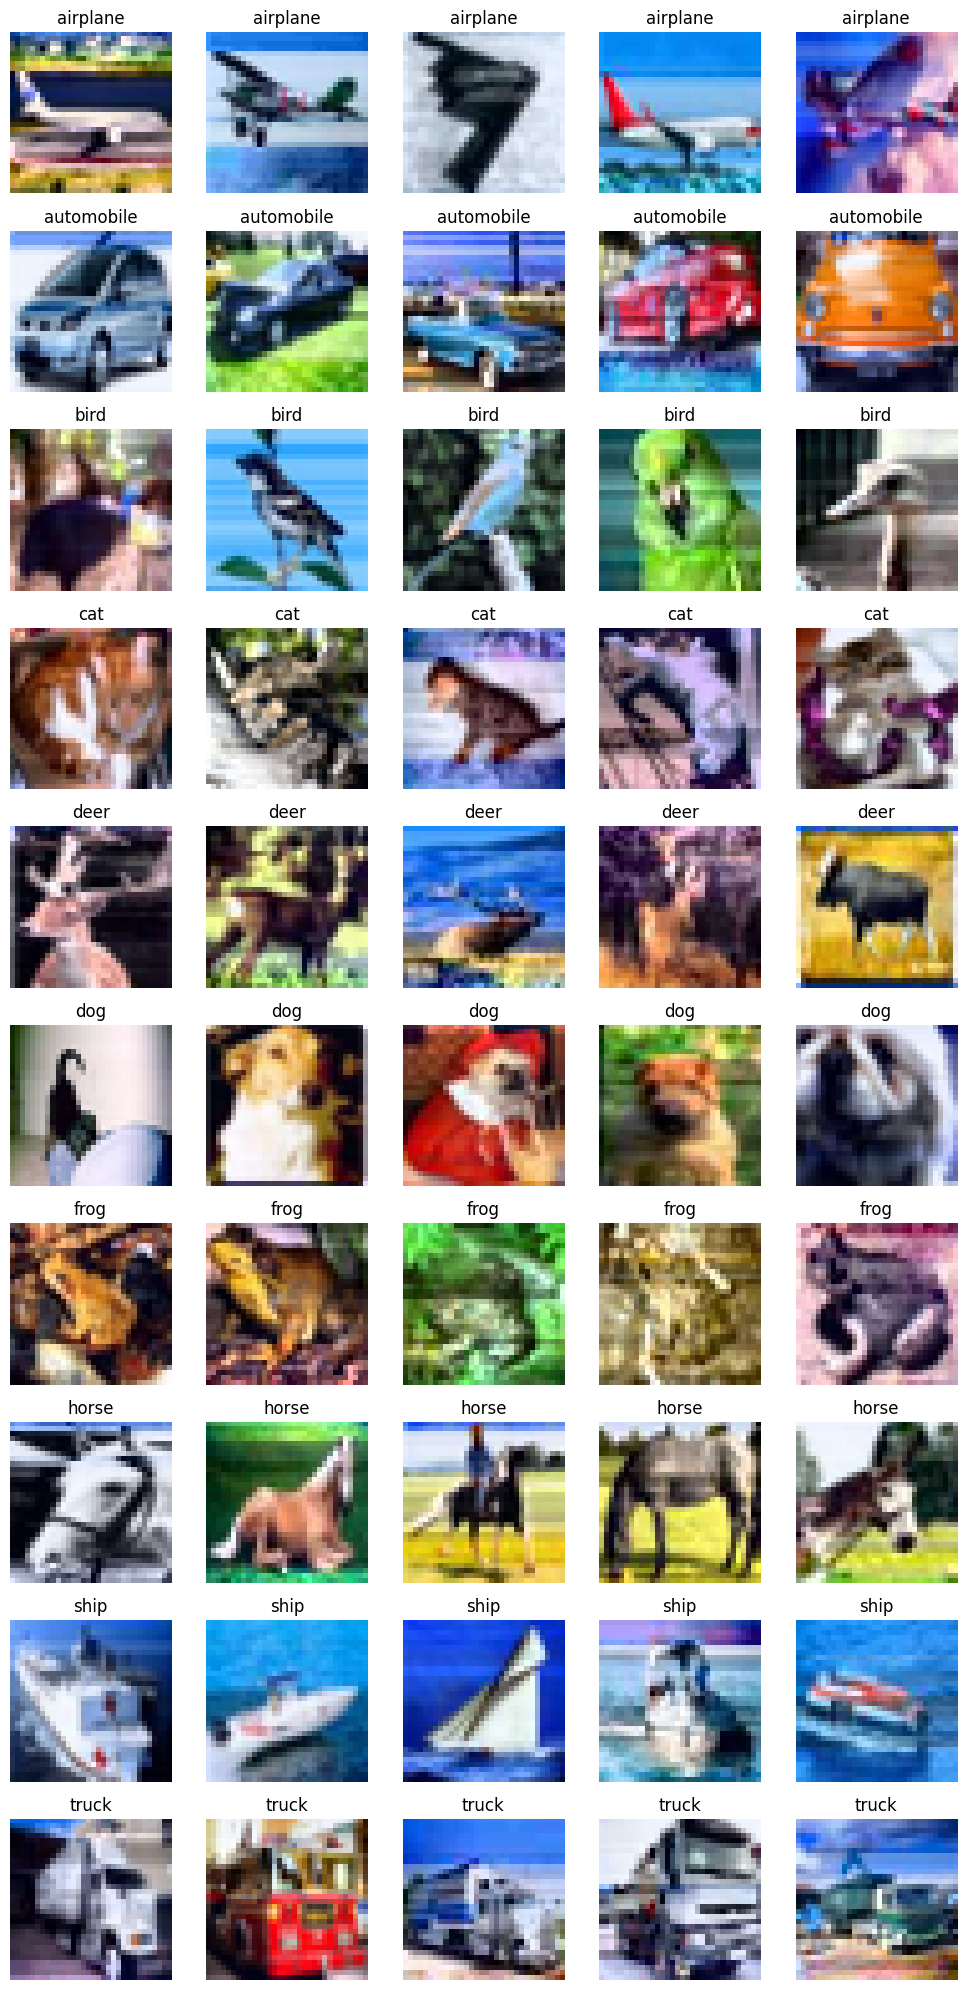

In [20]:
# Define class labels for CIFAR-10
class_labels = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

def min_max_normalize(image_array):
    image_array = np.asarray(image_array)
    min_val = image_array.min(axis=(1, 2), keepdims=True)  # Min per channel
    max_val = image_array.max(axis=(1, 2), keepdims=True)  # Max per channel
    range_val = max_val - min_val
    range_val[range_val == 0] = 1
    normalized_array = (image_array - min_val) / range_val
    return normalized_array

# Function to display random images and their labels from each class
def show_random_images_per_class(dataset, num_classes=10, images_per_class=5):
    fig, axs = plt.subplots(num_classes, images_per_class, figsize=(images_per_class * 2, num_classes * 2))
    axs = axs.flatten()
    samples_per_class = {i: 0 for i in range(num_classes)}

    # Randomly sample images from the dataset
    while any(samples_per_class[i] < images_per_class for i in range(num_classes)):
        index = random.randint(0, len(dataset) - 1)
        img, label = dataset[index]

        if samples_per_class[label] < images_per_class:
            ax = axs[label * images_per_class + samples_per_class[label]]
            img = min_max_normalize(img.permute(1, 2, 0).numpy())
            ax.imshow(img)
            ax.set_title(class_labels[label])
            ax.axis('off')
            samples_per_class[label] += 1

    plt.tight_layout()
    plt.show()
    
# Display random images and labels from each class
show_random_images_per_class(test_dataset)

# **Training Function**

In [21]:
# Function to evaluate the model
def evaluate_model(model, data_loader, criterion, device):
    model = model.to(device)
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / len(data_loader), 100 * correct / total

# Function to train the model
def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, device, best_model_path, num_epochs=30):
    model = model.to(device)
    best_val_loss = float('inf')
    early_stop_epoch = 1
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []    
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        
        # Training phase
        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device).long()

            # Forward pass and loss computation
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backpropagation and optimizer step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation phase
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        train_loss, train_accuracy = evaluate_model(model, train_loader, criterion, device)

        # Store metrics for analysis
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
                
        print(50*"=")
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_epoch = epoch + 1
            torch.save(model.state_dict(), best_model_path)

    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, early_stop_epoch, num_epochs)
    load_best_model(model, best_model_path)

    print(f"Training completed. Best model saved at epoch {early_stop_epoch}.")
    evaluate_and_log(model, train_loader, val_loader, test_loader, criterion, device)

# Function to plot training metrics
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, best_epoch, num_epochs):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.scatter(best_epoch, val_losses[best_epoch - 1], color='red', label='Best Model')
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.axvline(best_epoch, color='grey', linestyle='--', label='Best Epoch')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.scatter(best_epoch, val_accuracies[best_epoch - 1], color='red', label='Best Model')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.axvline(best_epoch, color='grey', linestyle='--', label='Best Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to load the best model
def load_best_model(model, path):
    model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
    print(f"Best model loaded from {path}.")

# Evaluate and log final metrics
def evaluate_and_log(model, train_loader, val_loader, test_loader, criterion, device):
    print("=" * 50)
    train_loss, train_accuracy = evaluate_model(model, train_loader, criterion, device)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    # return train_loss, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy


# **Define CNN BaseLine Model**

In [22]:
# Define the BaselineModel version 0
class BaselineModel_v0(nn.Module):
    def __init__(self):
        super(BaselineModel_v0, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 14 * 14, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 32 * 14 * 14)  # Flatten the tensor
        x = self.fc1(x)
        return x

Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 239.56it/s]


Epoch [1/30] - Train Loss: 1.2264, Train Acc: 57.84% - Val Loss: 1.2877, Val Acc: 54.65%


Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 242.87it/s]


Epoch [2/30] - Train Loss: 1.1417, Train Acc: 59.87% - Val Loss: 1.2308, Val Acc: 56.49%


Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 242.89it/s]


Epoch [3/30] - Train Loss: 1.0239, Train Acc: 64.64% - Val Loss: 1.1502, Val Acc: 60.14%


Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 241.42it/s]


Epoch [4/30] - Train Loss: 0.9375, Train Acc: 68.02% - Val Loss: 1.1041, Val Acc: 62.02%


Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 244.03it/s]


Epoch [5/30] - Train Loss: 0.9297, Train Acc: 67.76% - Val Loss: 1.1199, Val Acc: 61.37%


Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 244.08it/s]


Epoch [6/30] - Train Loss: 0.8460, Train Acc: 71.37% - Val Loss: 1.0642, Val Acc: 63.67%


Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 243.09it/s]


Epoch [7/30] - Train Loss: 0.8633, Train Acc: 70.19% - Val Loss: 1.1048, Val Acc: 62.48%


Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 244.50it/s]


Epoch [8/30] - Train Loss: 0.7907, Train Acc: 73.37% - Val Loss: 1.0723, Val Acc: 63.78%


Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 238.78it/s]


Epoch [9/30] - Train Loss: 0.7796, Train Acc: 73.37% - Val Loss: 1.0973, Val Acc: 63.81%


Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 243.96it/s]


Epoch [10/30] - Train Loss: 0.7346, Train Acc: 75.41% - Val Loss: 1.0668, Val Acc: 64.77%


Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 245.49it/s]


Epoch [11/30] - Train Loss: 0.7200, Train Acc: 75.60% - Val Loss: 1.0874, Val Acc: 63.55%


Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 246.19it/s]


Epoch [12/30] - Train Loss: 0.7233, Train Acc: 75.62% - Val Loss: 1.1276, Val Acc: 63.55%


Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 244.04it/s]


Epoch [13/30] - Train Loss: 0.6889, Train Acc: 76.77% - Val Loss: 1.1161, Val Acc: 63.59%


Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 241.85it/s]


Epoch [14/30] - Train Loss: 0.6436, Train Acc: 78.57% - Val Loss: 1.0982, Val Acc: 63.99%


Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 245.26it/s]


Epoch [15/30] - Train Loss: 0.6458, Train Acc: 78.32% - Val Loss: 1.1296, Val Acc: 63.99%


Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 240.28it/s]


Epoch [16/30] - Train Loss: 0.6745, Train Acc: 76.78% - Val Loss: 1.1838, Val Acc: 62.69%


Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 236.91it/s]


Epoch [17/30] - Train Loss: 0.6021, Train Acc: 79.77% - Val Loss: 1.1347, Val Acc: 64.64%


Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 239.53it/s]


Epoch [18/30] - Train Loss: 0.5881, Train Acc: 80.25% - Val Loss: 1.1467, Val Acc: 64.23%


Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 227.49it/s]


Epoch [19/30] - Train Loss: 0.5996, Train Acc: 79.48% - Val Loss: 1.1999, Val Acc: 63.03%


Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 236.70it/s]


Epoch [20/30] - Train Loss: 0.5516, Train Acc: 81.72% - Val Loss: 1.1662, Val Acc: 63.70%


Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 227.78it/s]


Epoch [21/30] - Train Loss: 0.5810, Train Acc: 79.96% - Val Loss: 1.2493, Val Acc: 62.38%


Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 234.90it/s]


Epoch [22/30] - Train Loss: 0.5265, Train Acc: 82.32% - Val Loss: 1.2076, Val Acc: 64.08%


Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 235.44it/s]


Epoch [23/30] - Train Loss: 0.5104, Train Acc: 83.11% - Val Loss: 1.2210, Val Acc: 63.60%


Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 237.61it/s]


Epoch [24/30] - Train Loss: 0.5349, Train Acc: 81.60% - Val Loss: 1.2812, Val Acc: 63.06%


Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 243.79it/s]


Epoch [25/30] - Train Loss: 0.5055, Train Acc: 82.85% - Val Loss: 1.2638, Val Acc: 63.64%


Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 242.05it/s]


Epoch [26/30] - Train Loss: 0.5081, Train Acc: 82.57% - Val Loss: 1.3108, Val Acc: 62.04%


Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 239.13it/s]


Epoch [27/30] - Train Loss: 0.4804, Train Acc: 83.75% - Val Loss: 1.3044, Val Acc: 62.79%


Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 239.26it/s]


Epoch [28/30] - Train Loss: 0.5240, Train Acc: 80.92% - Val Loss: 1.3812, Val Acc: 61.14%


Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 232.58it/s]


Epoch [29/30] - Train Loss: 0.4522, Train Acc: 84.78% - Val Loss: 1.3355, Val Acc: 62.67%


Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 236.43it/s]


Epoch [30/30] - Train Loss: 0.4506, Train Acc: 84.70% - Val Loss: 1.3631, Val Acc: 62.51%


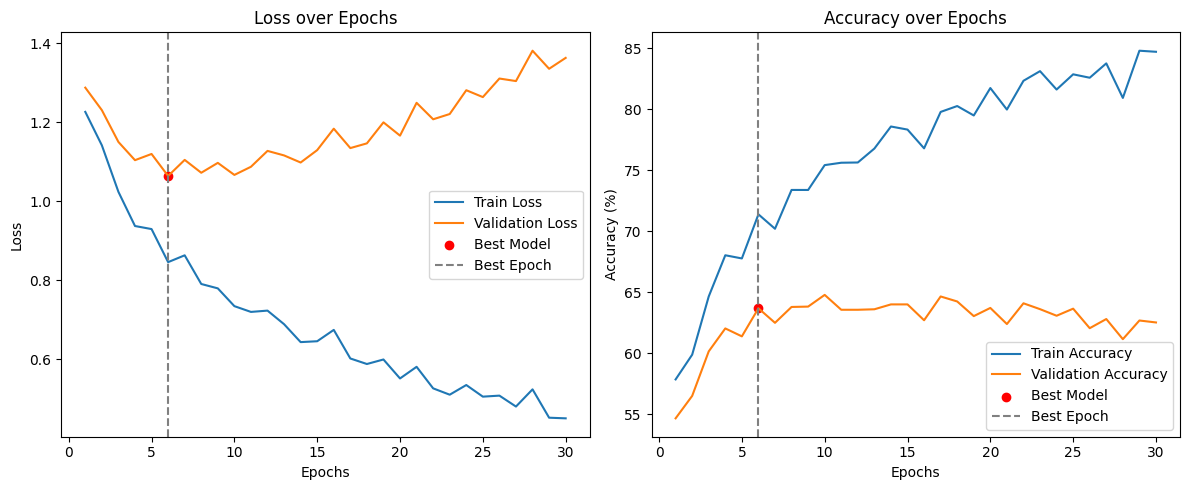

/tmp/ipykernel_23/3350674115.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))


Best model loaded from BMV0.pth.
Training completed. Best model saved at epoch 6.


Evaluating: 100%|██████████| 2500/2500 [00:10<00:00, 236.64it/s]


Train Loss: 0.8460, Train Accuracy: 71.37%


Evaluating: 100%|██████████| 625/625 [00:02<00:00, 235.38it/s]


Validation Loss: 1.0642, Validation Accuracy: 63.67%


Evaluating: 100%|██████████| 625/625 [00:02<00:00, 236.28it/s]

Test Loss: 1.0667, Test Accuracy: 64.21%


In [23]:
# Initialize model, criterion, and optimizer
BMV0 = BaselineModel_v0()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(BMV0.parameters(), lr=0.005)

train_model(BMV0, train_loader, val_loader, test_loader, criterion, optimizer, device, "BMV0.pth", num_epochs=30)

## **Considering that the loss on the training and validation data is high, we have a bias problem, and in the first step, we should use a more complex model. We can increase the number of fully connected layers and the number of convolutional layers.**

# **Train 3 different Model architecture and select best architecture**

In [39]:
class model_1(nn.Module):
    def __init__(self):
        super(model_1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding='same')
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding='same')
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)
        self.fc1 = nn.Linear(3 * 3 * 128, 160)
        self.fc2 = nn.Linear(160, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 3 * 3 * 128)  # Flatten the tensor
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

model 1:


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 218.80it/s]


Epoch [1/30] - Train Loss: 2.0134, Train Acc: 24.93% - Val Loss: 2.0111, Val Acc: 25.73%


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 219.00it/s]


Epoch [2/30] - Train Loss: 1.6725, Train Acc: 38.42% - Val Loss: 1.6638, Val Acc: 39.37%


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 222.70it/s]


Epoch [3/30] - Train Loss: 1.5224, Train Acc: 44.47% - Val Loss: 1.5122, Val Acc: 44.84%


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 217.63it/s]


Epoch [4/30] - Train Loss: 1.4194, Train Acc: 48.09% - Val Loss: 1.4182, Val Acc: 48.07%


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 218.71it/s]


Epoch [5/30] - Train Loss: 1.3443, Train Acc: 52.08% - Val Loss: 1.3511, Val Acc: 51.91%


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 221.91it/s]


Epoch [6/30] - Train Loss: 1.2296, Train Acc: 55.81% - Val Loss: 1.2552, Val Acc: 54.78%


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 217.59it/s]


Epoch [7/30] - Train Loss: 1.1084, Train Acc: 60.70% - Val Loss: 1.1403, Val Acc: 59.16%


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 219.55it/s]


Epoch [8/30] - Train Loss: 1.0427, Train Acc: 63.18% - Val Loss: 1.0908, Val Acc: 61.46%


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 223.37it/s]


Epoch [9/30] - Train Loss: 0.9752, Train Acc: 65.27% - Val Loss: 1.0351, Val Acc: 63.50%


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 224.65it/s]


Epoch [10/30] - Train Loss: 0.9049, Train Acc: 68.28% - Val Loss: 0.9779, Val Acc: 65.93%


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 222.97it/s]


Epoch [11/30] - Train Loss: 0.8462, Train Acc: 70.62% - Val Loss: 0.9355, Val Acc: 67.27%


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 221.69it/s]


Epoch [12/30] - Train Loss: 0.8142, Train Acc: 71.61% - Val Loss: 0.9241, Val Acc: 68.52%


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 220.05it/s]


Epoch [13/30] - Train Loss: 0.7929, Train Acc: 71.94% - Val Loss: 0.9366, Val Acc: 67.57%


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 223.68it/s]


Epoch [14/30] - Train Loss: 0.7197, Train Acc: 74.96% - Val Loss: 0.8594, Val Acc: 70.20%


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 222.73it/s]


Epoch [15/30] - Train Loss: 0.7096, Train Acc: 75.24% - Val Loss: 0.8789, Val Acc: 70.23%


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 224.23it/s]


Epoch [16/30] - Train Loss: 0.6497, Train Acc: 77.05% - Val Loss: 0.8485, Val Acc: 70.93%


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 226.54it/s]


Epoch [17/30] - Train Loss: 0.6020, Train Acc: 79.05% - Val Loss: 0.8192, Val Acc: 72.21%


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 225.94it/s]


Epoch [18/30] - Train Loss: 0.5589, Train Acc: 80.80% - Val Loss: 0.8010, Val Acc: 73.04%


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 221.06it/s]


Epoch [19/30] - Train Loss: 0.5117, Train Acc: 82.19% - Val Loss: 0.7960, Val Acc: 72.79%


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 221.85it/s]


Epoch [20/30] - Train Loss: 0.4654, Train Acc: 83.91% - Val Loss: 0.7982, Val Acc: 73.37%


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 223.17it/s]


Epoch [21/30] - Train Loss: 0.4333, Train Acc: 85.08% - Val Loss: 0.7748, Val Acc: 74.16%


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 224.53it/s]


Epoch [22/30] - Train Loss: 0.3921, Train Acc: 86.68% - Val Loss: 0.7764, Val Acc: 74.44%


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 220.24it/s]


Epoch [23/30] - Train Loss: 0.3591, Train Acc: 87.89% - Val Loss: 0.7939, Val Acc: 74.80%


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 221.66it/s]


Epoch [24/30] - Train Loss: 0.3516, Train Acc: 87.98% - Val Loss: 0.8479, Val Acc: 73.41%


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 223.28it/s]


Epoch [25/30] - Train Loss: 0.2857, Train Acc: 90.67% - Val Loss: 0.8180, Val Acc: 74.86%


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 222.58it/s]


Epoch [26/30] - Train Loss: 0.2459, Train Acc: 92.36% - Val Loss: 0.8212, Val Acc: 74.90%


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 224.88it/s]


Epoch [27/30] - Train Loss: 0.2212, Train Acc: 92.92% - Val Loss: 0.8635, Val Acc: 74.83%


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 219.23it/s]


Epoch [28/30] - Train Loss: 0.1964, Train Acc: 93.48% - Val Loss: 0.9009, Val Acc: 74.96%


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 221.62it/s]


Epoch [29/30] - Train Loss: 0.1899, Train Acc: 93.56% - Val Loss: 0.9686, Val Acc: 73.81%


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 223.75it/s]


Epoch [30/30] - Train Loss: 0.1848, Train Acc: 93.66% - Val Loss: 1.0149, Val Acc: 74.04%


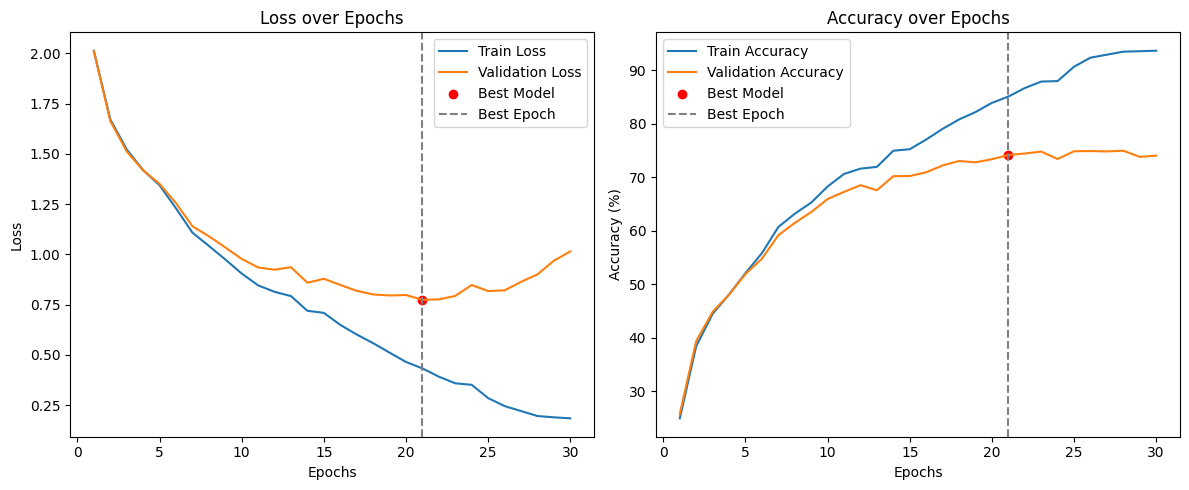

/tmp/ipykernel_23/3350674115.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))


Best model loaded from model_1.pth.
Training completed. Best model saved at epoch 21.


Evaluating: 100%|██████████| 2500/2500 [00:11<00:00, 221.09it/s]


Train Loss: 0.4333, Train Accuracy: 85.08%


Evaluating: 100%|██████████| 625/625 [00:02<00:00, 223.82it/s]


Validation Loss: 0.7748, Validation Accuracy: 74.16%


Evaluating: 100%|██████████| 625/625 [00:02<00:00, 223.10it/s]

Test Loss: 0.8140, Test Accuracy: 72.83%


In [25]:
print("model 1:")
model_1 = model_1()
optimizer = optim.SGD(model_1.parameters(), lr=0.0025)
train_model(model_1, train_loader, val_loader, test_loader, criterion, optimizer, device, "model_1.pth", num_epochs=30)
print(100*"=")

In [ ]:
class model_2(nn.Module):
    def __init__(self):
        super(model_2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding='same')
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same')
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=320, kernel_size=3)
        self.fc1 = nn.Linear(6 * 6 * 320, 160)
        self.fc2 = nn.Linear(160, 80)
        self.fc3 = nn.Linear(80, 10)  # 10 classes for CIFAR-10

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 6 * 6 * 320)  # Flatten the tensor
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

model 2:


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 192.06it/s]


Epoch [1/30] - Train Loss: 2.0980, Train Acc: 25.19% - Val Loss: 2.0939, Val Acc: 25.29%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 196.55it/s]


Epoch [2/30] - Train Loss: 1.7417, Train Acc: 37.23% - Val Loss: 1.7384, Val Acc: 37.07%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 189.23it/s]


Epoch [3/30] - Train Loss: 1.5579, Train Acc: 43.25% - Val Loss: 1.5565, Val Acc: 43.09%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 190.36it/s]


Epoch [4/30] - Train Loss: 1.4107, Train Acc: 49.21% - Val Loss: 1.4127, Val Acc: 48.53%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 189.11it/s]


Epoch [5/30] - Train Loss: 1.3268, Train Acc: 52.39% - Val Loss: 1.3351, Val Acc: 52.75%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 196.62it/s]


Epoch [6/30] - Train Loss: 1.3291, Train Acc: 53.56% - Val Loss: 1.3488, Val Acc: 52.78%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 191.67it/s]


Epoch [7/30] - Train Loss: 1.1285, Train Acc: 59.94% - Val Loss: 1.1685, Val Acc: 58.63%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 195.74it/s]


Epoch [8/30] - Train Loss: 1.0550, Train Acc: 63.04% - Val Loss: 1.1077, Val Acc: 60.91%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 192.18it/s]


Epoch [9/30] - Train Loss: 1.0621, Train Acc: 62.86% - Val Loss: 1.1303, Val Acc: 60.80%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 196.25it/s]


Epoch [10/30] - Train Loss: 0.8778, Train Acc: 69.31% - Val Loss: 0.9753, Val Acc: 66.30%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 192.24it/s]


Epoch [11/30] - Train Loss: 0.8039, Train Acc: 72.00% - Val Loss: 0.9183, Val Acc: 68.17%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 197.04it/s]


Epoch [12/30] - Train Loss: 0.7642, Train Acc: 73.60% - Val Loss: 0.9169, Val Acc: 67.96%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 192.29it/s]


Epoch [13/30] - Train Loss: 0.6793, Train Acc: 76.67% - Val Loss: 0.8648, Val Acc: 69.94%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 194.92it/s]


Epoch [14/30] - Train Loss: 0.6194, Train Acc: 78.75% - Val Loss: 0.8498, Val Acc: 70.72%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 193.54it/s]


Epoch [15/30] - Train Loss: 0.5863, Train Acc: 79.67% - Val Loss: 0.8554, Val Acc: 70.49%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 191.75it/s]


Epoch [16/30] - Train Loss: 0.4936, Train Acc: 83.00% - Val Loss: 0.8253, Val Acc: 72.31%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 197.27it/s]


Epoch [17/30] - Train Loss: 0.4233, Train Acc: 86.00% - Val Loss: 0.8092, Val Acc: 72.91%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 194.26it/s]


Epoch [18/30] - Train Loss: 0.3764, Train Acc: 87.70% - Val Loss: 0.8324, Val Acc: 73.27%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 198.16it/s]


Epoch [19/30] - Train Loss: 0.2992, Train Acc: 90.54% - Val Loss: 0.8264, Val Acc: 73.20%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 196.07it/s]


Epoch [20/30] - Train Loss: 0.2376, Train Acc: 92.59% - Val Loss: 0.8631, Val Acc: 73.84%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 198.72it/s]


Epoch [21/30] - Train Loss: 0.1885, Train Acc: 94.38% - Val Loss: 0.9163, Val Acc: 73.44%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 195.88it/s]


Epoch [22/30] - Train Loss: 0.2412, Train Acc: 91.21% - Val Loss: 1.1031, Val Acc: 71.89%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 198.70it/s]


Epoch [23/30] - Train Loss: 0.1601, Train Acc: 94.43% - Val Loss: 1.1165, Val Acc: 72.31%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 193.69it/s]


Epoch [24/30] - Train Loss: 0.0897, Train Acc: 97.24% - Val Loss: 1.1245, Val Acc: 73.98%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 197.73it/s]


Epoch [25/30] - Train Loss: 0.0912, Train Acc: 97.22% - Val Loss: 1.2107, Val Acc: 72.32%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 194.15it/s]


Epoch [26/30] - Train Loss: 0.0522, Train Acc: 98.54% - Val Loss: 1.2872, Val Acc: 73.43%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 194.80it/s]


Epoch [27/30] - Train Loss: 0.0717, Train Acc: 97.55% - Val Loss: 1.4793, Val Acc: 72.96%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 193.52it/s]


Epoch [28/30] - Train Loss: 0.0439, Train Acc: 98.65% - Val Loss: 1.4589, Val Acc: 73.46%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 194.31it/s]


Epoch [29/30] - Train Loss: 0.0245, Train Acc: 99.38% - Val Loss: 1.4666, Val Acc: 73.76%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 193.47it/s]


Epoch [30/30] - Train Loss: 0.0498, Train Acc: 98.36% - Val Loss: 1.6778, Val Acc: 73.05%


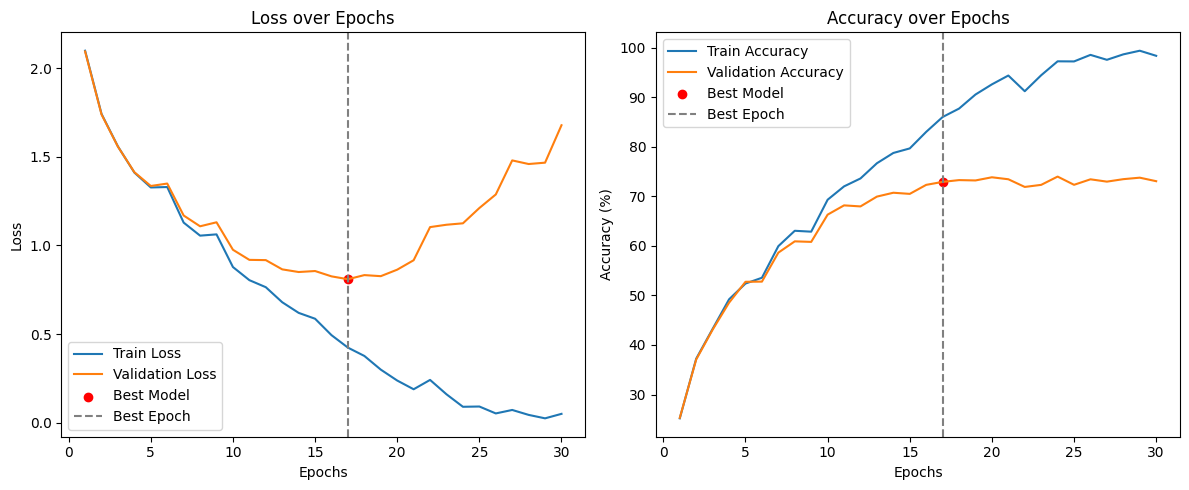

/tmp/ipykernel_23/3350674115.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))


Best model loaded from model_2.pth.
Training completed. Best model saved at epoch 17.


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 193.11it/s]


Train Loss: 0.4233, Train Accuracy: 86.00%


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 196.32it/s]


Validation Loss: 0.8092, Validation Accuracy: 72.91%


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 191.96it/s]

Test Loss: 0.8341, Test Accuracy: 72.09%


In [27]:

print("model 2:")
model_2 = model_2()
optimizer = optim.SGD(model_2.parameters(), lr=0.0025)
train_model(model_2, train_loader, val_loader, test_loader, criterion, optimizer, device, "model_2.pth", num_epochs=30)
print(100*"=")


In [ ]:
class model_3(nn.Module):
    def __init__(self):
        super(model_3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding='same')
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=256, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=32, kernel_size=3)
        self.fc1 = nn.Linear(5 * 5 * 32, 160)
        self.fc2 = nn.Linear(160, 80)
        self.fc3 = nn.Linear(80, 10)  # 10 classes for CIFAR-10

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 5 * 5 * 32)  # Flatten the tensor
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

model 3:


Evaluating: 100%|██████████| 2500/2500 [00:14<00:00, 174.52it/s]


Epoch [1/30] - Train Loss: 2.2791, Train Acc: 20.28% - Val Loss: 2.2787, Val Acc: 20.03%


Evaluating: 100%|██████████| 2500/2500 [00:14<00:00, 178.41it/s]


Epoch [2/30] - Train Loss: 1.8872, Train Acc: 32.77% - Val Loss: 1.8857, Val Acc: 32.39%


Evaluating: 100%|██████████| 2500/2500 [00:14<00:00, 178.30it/s]


Epoch [3/30] - Train Loss: 1.7299, Train Acc: 37.94% - Val Loss: 1.7310, Val Acc: 38.28%


Evaluating: 100%|██████████| 2500/2500 [00:14<00:00, 172.13it/s]


Epoch [4/30] - Train Loss: 1.6076, Train Acc: 41.48% - Val Loss: 1.6103, Val Acc: 41.39%


Evaluating: 100%|██████████| 2500/2500 [00:14<00:00, 176.64it/s]


Epoch [5/30] - Train Loss: 1.5317, Train Acc: 44.09% - Val Loss: 1.5402, Val Acc: 43.82%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 181.05it/s]


Epoch [6/30] - Train Loss: 1.4603, Train Acc: 47.15% - Val Loss: 1.4769, Val Acc: 46.69%


Evaluating: 100%|██████████| 2500/2500 [00:14<00:00, 176.02it/s]


Epoch [7/30] - Train Loss: 1.3947, Train Acc: 50.01% - Val Loss: 1.4125, Val Acc: 49.26%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 179.89it/s]


Epoch [8/30] - Train Loss: 1.3390, Train Acc: 51.59% - Val Loss: 1.3733, Val Acc: 50.49%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 181.24it/s]


Epoch [9/30] - Train Loss: 1.2799, Train Acc: 53.99% - Val Loss: 1.3255, Val Acc: 52.67%


Evaluating: 100%|██████████| 2500/2500 [00:14<00:00, 177.76it/s]


Epoch [10/30] - Train Loss: 1.2929, Train Acc: 53.82% - Val Loss: 1.3476, Val Acc: 52.39%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 180.74it/s]


Epoch [11/30] - Train Loss: 1.1852, Train Acc: 58.04% - Val Loss: 1.2495, Val Acc: 56.10%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 180.36it/s]


Epoch [12/30] - Train Loss: 1.1392, Train Acc: 59.63% - Val Loss: 1.2185, Val Acc: 57.07%


Evaluating: 100%|██████████| 2500/2500 [00:14<00:00, 176.97it/s]


Epoch [13/30] - Train Loss: 1.1120, Train Acc: 60.56% - Val Loss: 1.2010, Val Acc: 57.50%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 180.24it/s]


Epoch [14/30] - Train Loss: 1.0672, Train Acc: 62.31% - Val Loss: 1.1620, Val Acc: 59.25%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 181.50it/s]


Epoch [15/30] - Train Loss: 1.0162, Train Acc: 64.54% - Val Loss: 1.1308, Val Acc: 60.14%


Evaluating: 100%|██████████| 2500/2500 [00:14<00:00, 178.40it/s]


Epoch [16/30] - Train Loss: 0.9685, Train Acc: 66.23% - Val Loss: 1.1011, Val Acc: 61.65%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 181.34it/s]


Epoch [17/30] - Train Loss: 0.9404, Train Acc: 66.92% - Val Loss: 1.0891, Val Acc: 62.21%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 181.96it/s]


Epoch [18/30] - Train Loss: 0.8724, Train Acc: 70.09% - Val Loss: 1.0340, Val Acc: 63.49%


Evaluating: 100%|██████████| 2500/2500 [00:14<00:00, 170.83it/s]


Epoch [19/30] - Train Loss: 0.8532, Train Acc: 70.31% - Val Loss: 1.0220, Val Acc: 64.63%


Evaluating: 100%|██████████| 2500/2500 [00:14<00:00, 177.62it/s]


Epoch [20/30] - Train Loss: 0.8177, Train Acc: 71.45% - Val Loss: 1.0103, Val Acc: 64.68%


Evaluating: 100%|██████████| 2500/2500 [00:14<00:00, 177.17it/s]


Epoch [21/30] - Train Loss: 0.7657, Train Acc: 73.23% - Val Loss: 0.9910, Val Acc: 66.04%


Evaluating: 100%|██████████| 2500/2500 [00:14<00:00, 174.90it/s]


Epoch [22/30] - Train Loss: 0.7545, Train Acc: 73.99% - Val Loss: 0.9921, Val Acc: 65.96%


Evaluating: 100%|██████████| 2500/2500 [00:14<00:00, 178.37it/s]


Epoch [23/30] - Train Loss: 0.7515, Train Acc: 73.75% - Val Loss: 1.0017, Val Acc: 66.03%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 180.79it/s]


Epoch [24/30] - Train Loss: 0.6972, Train Acc: 75.92% - Val Loss: 0.9741, Val Acc: 66.80%


Evaluating: 100%|██████████| 2500/2500 [00:14<00:00, 176.87it/s]


Epoch [25/30] - Train Loss: 0.6682, Train Acc: 76.47% - Val Loss: 0.9702, Val Acc: 67.19%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 179.33it/s]


Epoch [26/30] - Train Loss: 0.6199, Train Acc: 78.24% - Val Loss: 0.9536, Val Acc: 67.95%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 180.16it/s]


Epoch [27/30] - Train Loss: 0.5689, Train Acc: 80.49% - Val Loss: 0.9526, Val Acc: 68.38%


Evaluating: 100%|██████████| 2500/2500 [00:14<00:00, 175.99it/s]


Epoch [28/30] - Train Loss: 0.5875, Train Acc: 79.66% - Val Loss: 1.0046, Val Acc: 67.33%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 180.59it/s]


Epoch [29/30] - Train Loss: 0.5197, Train Acc: 82.11% - Val Loss: 0.9763, Val Acc: 68.34%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 180.13it/s]


Epoch [30/30] - Train Loss: 0.4842, Train Acc: 83.54% - Val Loss: 0.9574, Val Acc: 69.11%


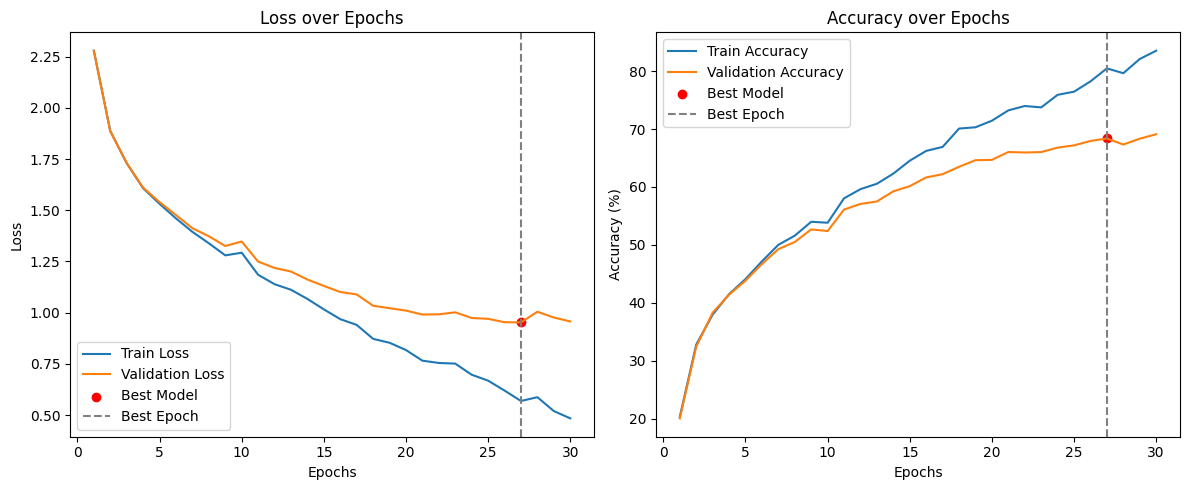

/tmp/ipykernel_23/3350674115.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))


Best model loaded from model_3.pth.
Training completed. Best model saved at epoch 27.


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 180.62it/s]


Train Loss: 0.5689, Train Accuracy: 80.49%


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 178.58it/s]


Validation Loss: 0.9526, Validation Accuracy: 68.38%


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 175.83it/s]

Test Loss: 0.9724, Test Accuracy: 68.17%


In [29]:

print("model 3:")
model_3 = model_3()
optimizer = optim.SGD(model_3.parameters(), lr=0.0025)
train_model(model_3, train_loader, val_loader, test_loader, criterion, optimizer, device, "model_3.pth", num_epochs=30)
print(100*"=")

## **Among the three models that were introduced and trained, I choose the architecture of the second model because it has demonstrated good accuracy and low loss, while also having the potential to overfit on the training data. I will later address the overfitting issue using regularization techniques.**

In [30]:
# Define the BaselineModel version 1
class BaselineModel_v1(nn.Module):
    def __init__(self):
        super(BaselineModel_v1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding='same')
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same')
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=320, kernel_size=3)
        self.fc1 = nn.Linear(6 * 6 * 320, 160)
        self.fc2 = nn.Linear(160, 80)
        self.fc3 = nn.Linear(80, 10)  # 10 classes for CIFAR-10

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 6 * 6 * 320)  # Flatten the tensor
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 199.34it/s]


Epoch [1/30] - Train Loss: 2.2169, Train Acc: 19.58% - Val Loss: 2.2185, Val Acc: 18.99%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 193.69it/s]


Epoch [2/30] - Train Loss: 1.7440, Train Acc: 37.21% - Val Loss: 1.7342, Val Acc: 37.92%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 199.24it/s]


Epoch [3/30] - Train Loss: 1.5353, Train Acc: 43.93% - Val Loss: 1.5310, Val Acc: 43.59%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 196.77it/s]


Epoch [4/30] - Train Loss: 1.4557, Train Acc: 46.85% - Val Loss: 1.4523, Val Acc: 46.94%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 200.25it/s]


Epoch [5/30] - Train Loss: 1.3470, Train Acc: 52.01% - Val Loss: 1.3545, Val Acc: 51.75%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 193.96it/s]


Epoch [6/30] - Train Loss: 1.3168, Train Acc: 52.96% - Val Loss: 1.3361, Val Acc: 52.50%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 196.22it/s]


Epoch [7/30] - Train Loss: 1.1936, Train Acc: 57.59% - Val Loss: 1.2148, Val Acc: 57.20%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 193.04it/s]


Epoch [8/30] - Train Loss: 1.0806, Train Acc: 62.08% - Val Loss: 1.1232, Val Acc: 60.58%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 195.93it/s]


Epoch [9/30] - Train Loss: 1.0508, Train Acc: 63.21% - Val Loss: 1.1093, Val Acc: 60.97%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 198.24it/s]


Epoch [10/30] - Train Loss: 0.9734, Train Acc: 66.12% - Val Loss: 1.0511, Val Acc: 63.05%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 193.15it/s]


Epoch [11/30] - Train Loss: 0.8591, Train Acc: 70.23% - Val Loss: 0.9618, Val Acc: 66.55%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 196.75it/s]


Epoch [12/30] - Train Loss: 0.8139, Train Acc: 71.73% - Val Loss: 0.9352, Val Acc: 67.59%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 194.64it/s]


Epoch [13/30] - Train Loss: 0.7204, Train Acc: 75.17% - Val Loss: 0.8637, Val Acc: 69.83%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 199.03it/s]


Epoch [14/30] - Train Loss: 0.6709, Train Acc: 76.66% - Val Loss: 0.8551, Val Acc: 69.99%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 196.09it/s]


Epoch [15/30] - Train Loss: 0.5835, Train Acc: 80.21% - Val Loss: 0.8054, Val Acc: 71.88%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 198.84it/s]


Epoch [16/30] - Train Loss: 0.5513, Train Acc: 81.17% - Val Loss: 0.8130, Val Acc: 71.80%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 195.42it/s]


Epoch [17/30] - Train Loss: 0.5217, Train Acc: 81.91% - Val Loss: 0.8450, Val Acc: 71.23%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 198.27it/s]


Epoch [18/30] - Train Loss: 0.4129, Train Acc: 86.00% - Val Loss: 0.7835, Val Acc: 73.73%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 193.64it/s]


Epoch [19/30] - Train Loss: 0.3979, Train Acc: 86.36% - Val Loss: 0.8409, Val Acc: 72.97%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 196.80it/s]


Epoch [20/30] - Train Loss: 0.3179, Train Acc: 89.27% - Val Loss: 0.8302, Val Acc: 73.56%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 193.46it/s]


Epoch [21/30] - Train Loss: 0.2683, Train Acc: 91.17% - Val Loss: 0.8656, Val Acc: 73.90%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 196.44it/s]


Epoch [22/30] - Train Loss: 0.2360, Train Acc: 92.24% - Val Loss: 0.9130, Val Acc: 73.62%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 195.46it/s]


Epoch [23/30] - Train Loss: 0.1539, Train Acc: 95.47% - Val Loss: 0.9091, Val Acc: 74.49%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 199.48it/s]


Epoch [24/30] - Train Loss: 0.1345, Train Acc: 95.89% - Val Loss: 0.9803, Val Acc: 74.13%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 195.14it/s]


Epoch [25/30] - Train Loss: 0.0877, Train Acc: 97.58% - Val Loss: 1.0517, Val Acc: 74.73%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 198.05it/s]


Epoch [26/30] - Train Loss: 0.1095, Train Acc: 96.29% - Val Loss: 1.1493, Val Acc: 73.67%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 194.61it/s]


Epoch [27/30] - Train Loss: 0.0711, Train Acc: 97.73% - Val Loss: 1.2603, Val Acc: 74.19%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 198.34it/s]


Epoch [28/30] - Train Loss: 0.0610, Train Acc: 98.08% - Val Loss: 1.2996, Val Acc: 73.79%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 192.52it/s]


Epoch [29/30] - Train Loss: 0.0322, Train Acc: 99.23% - Val Loss: 1.3304, Val Acc: 74.75%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 198.73it/s]


Epoch [30/30] - Train Loss: 0.0287, Train Acc: 99.24% - Val Loss: 1.4085, Val Acc: 75.02%


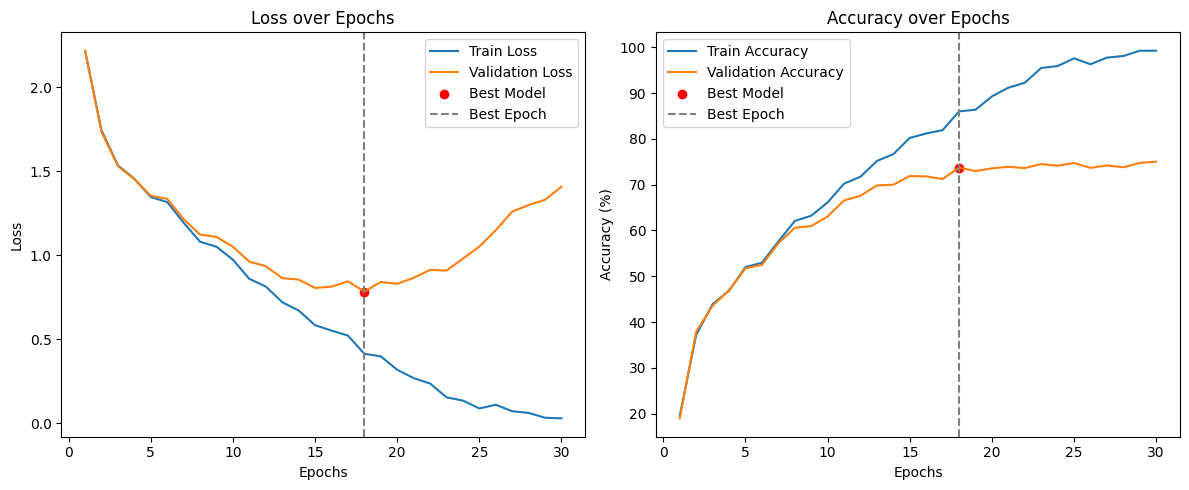

/tmp/ipykernel_23/3350674115.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))


Best model loaded from BMV1.pth.
Training completed. Best model saved at epoch 18.


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 194.02it/s]


Train Loss: 0.4129, Train Accuracy: 86.00%


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 194.55it/s]


Validation Loss: 0.7835, Validation Accuracy: 73.73%


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 196.69it/s]

Test Loss: 0.7988, Test Accuracy: 73.35%


In [31]:
# Initialize model, criterion, and optimizer
BMV1 = BaselineModel_v1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(BMV1.parameters(), lr=0.0025)

train_model(BMV1, train_loader, val_loader, test_loader, criterion, optimizer, device, "BMV1.pth", num_epochs=30)

## As expected, increasing the complexity of the network by deepening it helped to resolve the bias problem. However, as indicated by the loss curves based on the epochs for the training and validation data, the model has overfitted on the training data and is experiencing a variance problem. To address this issue, we will use regularization techniques like Batch Normalization and Dropout.

# Batch Normalization only
## Placement of Normalization Layers in Neural Networks

**Batch Normalization** is a popular technique used to improve the training of deep neural networks by normalizing the input of each layer so that the mean output activation is zero and the standard deviation is one. Here’s how and where to place batch normalization layers:

#### 1. **After Convolutional Layers**:
- **Typical Placement**: Place batch normalization **after the convolutional layer** and **before the activation function**.
- **Purpose**: This normalizes the outputs of the convolutional layer to stabilize the learning process and help the network converge faster.

```python
x = self.conv1(x)
x = self.bn1(x)
x = self.relu(x)
```

#### 2. **After Fully Connected (Dense) Layers**:
- **Usage**: Batch normalization can also be used after fully connected layers. 
- **Purpose**: This helps to stabilize the outputs of these layers, especially in deeper networks.

```python
x = self.fc1(x)
x = self.bn_fc1(x)
x = self.relu(x)
```

### Do Fully Connected Sections Need Batch Normalization?

#### **Why Use Batch Normalization in Fully Connected Layers?**
- **Stabilizes Learning**: Batch normalization stabilizes the learning process by maintaining a consistent mean and variance of inputs across the layers.
- **Improves Performance**: It can improve the performance of deep networks by allowing them to use higher learning rates and reducing the sensitivity to initialization.

#### **When Might It Be Less Useful?**
- **Simpler Models**: In simpler models or networks with fewer layers, the benefits might be less pronounced.
- **Regularization Redundancy**: If other regularization techniques (like dropout) are heavily used, the additional benefit of batch normalization might be marginal.

### Then:

- **Batch Normalization after Convolutional Layers**: Improves stability and performance.
- **Batch Normalization in Fully Connected Layers**: Can be beneficial, especially in deeper networks.
- **Placement**: Place batch normalization between the layer and the activation function.

In [32]:
# Define Baseline Model version 2
class BaselineModel_v2(nn.Module):
    def __init__(self):
        super(BaselineModel_v2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=320, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(320)
        self.fc1 = nn.Linear(6 * 6 * 320, 160)
        self.fc2 = nn.Linear(160, 80)
        self.fc3 = nn.Linear(80, 10)  # 10 classes for CIFAR-10

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 6 * 6 * 320)  # Flatten the tensor
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 197.85it/s]


Epoch [1/30] - Train Loss: 1.2413, Train Acc: 56.66% - Val Loss: 1.2553, Val Acc: 55.67%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 196.52it/s]


Epoch [2/30] - Train Loss: 0.9994, Train Acc: 63.98% - Val Loss: 1.0532, Val Acc: 61.79%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 194.33it/s]


Epoch [3/30] - Train Loss: 0.8768, Train Acc: 68.70% - Val Loss: 0.9671, Val Acc: 65.36%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 195.89it/s]


Epoch [4/30] - Train Loss: 0.7365, Train Acc: 74.59% - Val Loss: 0.8760, Val Acc: 69.43%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 195.43it/s]


Epoch [5/30] - Train Loss: 0.5948, Train Acc: 79.48% - Val Loss: 0.7828, Val Acc: 72.97%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 195.71it/s]


Epoch [6/30] - Train Loss: 0.5630, Train Acc: 80.73% - Val Loss: 0.8096, Val Acc: 72.01%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 199.08it/s]


Epoch [7/30] - Train Loss: 0.4321, Train Acc: 85.45% - Val Loss: 0.7450, Val Acc: 74.64%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 194.49it/s]


Epoch [8/30] - Train Loss: 0.3508, Train Acc: 89.00% - Val Loss: 0.7285, Val Acc: 74.90%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 196.70it/s]


Epoch [9/30] - Train Loss: 0.2796, Train Acc: 91.75% - Val Loss: 0.7390, Val Acc: 75.38%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 195.61it/s]


Epoch [10/30] - Train Loss: 0.2677, Train Acc: 91.30% - Val Loss: 0.8353, Val Acc: 74.00%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 196.63it/s]


Epoch [11/30] - Train Loss: 0.2251, Train Acc: 92.40% - Val Loss: 0.8749, Val Acc: 73.20%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 194.31it/s]


Epoch [12/30] - Train Loss: 0.1486, Train Acc: 95.44% - Val Loss: 0.8661, Val Acc: 74.83%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 198.14it/s]


Epoch [13/30] - Train Loss: 0.0874, Train Acc: 98.09% - Val Loss: 0.8296, Val Acc: 75.71%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 193.84it/s]


Epoch [14/30] - Train Loss: 0.0614, Train Acc: 98.79% - Val Loss: 0.8335, Val Acc: 75.72%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 198.92it/s]


Epoch [15/30] - Train Loss: 0.0365, Train Acc: 99.62% - Val Loss: 0.8510, Val Acc: 76.24%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 194.22it/s]


Epoch [16/30] - Train Loss: 0.0211, Train Acc: 99.89% - Val Loss: 0.8545, Val Acc: 76.83%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 193.71it/s]


Epoch [17/30] - Train Loss: 0.0139, Train Acc: 99.95% - Val Loss: 0.8912, Val Acc: 76.94%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 194.41it/s]


Epoch [18/30] - Train Loss: 0.0079, Train Acc: 99.99% - Val Loss: 0.8872, Val Acc: 77.22%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 195.25it/s]


Epoch [19/30] - Train Loss: 0.0069, Train Acc: 100.00% - Val Loss: 0.8893, Val Acc: 77.53%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 198.84it/s]


Epoch [20/30] - Train Loss: 0.0049, Train Acc: 100.00% - Val Loss: 0.8971, Val Acc: 77.63%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 194.06it/s]


Epoch [21/30] - Train Loss: 0.0041, Train Acc: 100.00% - Val Loss: 0.9105, Val Acc: 77.41%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 198.50it/s]


Epoch [22/30] - Train Loss: 0.0031, Train Acc: 100.00% - Val Loss: 0.9166, Val Acc: 77.60%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 194.23it/s]


Epoch [23/30] - Train Loss: 0.0028, Train Acc: 100.00% - Val Loss: 0.9258, Val Acc: 77.72%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 197.29it/s]


Epoch [24/30] - Train Loss: 0.0023, Train Acc: 100.00% - Val Loss: 0.9451, Val Acc: 77.45%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 193.94it/s]


Epoch [25/30] - Train Loss: 0.0020, Train Acc: 100.00% - Val Loss: 0.9407, Val Acc: 77.64%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 196.43it/s]


Epoch [26/30] - Train Loss: 0.0022, Train Acc: 100.00% - Val Loss: 0.9733, Val Acc: 77.54%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 194.87it/s]


Epoch [27/30] - Train Loss: 0.0016, Train Acc: 100.00% - Val Loss: 0.9662, Val Acc: 77.85%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 194.16it/s]


Epoch [28/30] - Train Loss: 0.0014, Train Acc: 100.00% - Val Loss: 0.9653, Val Acc: 77.60%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 196.02it/s]


Epoch [29/30] - Train Loss: 0.0014, Train Acc: 100.00% - Val Loss: 0.9644, Val Acc: 77.75%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 195.37it/s]


Epoch [30/30] - Train Loss: 0.0013, Train Acc: 100.00% - Val Loss: 0.9774, Val Acc: 77.76%


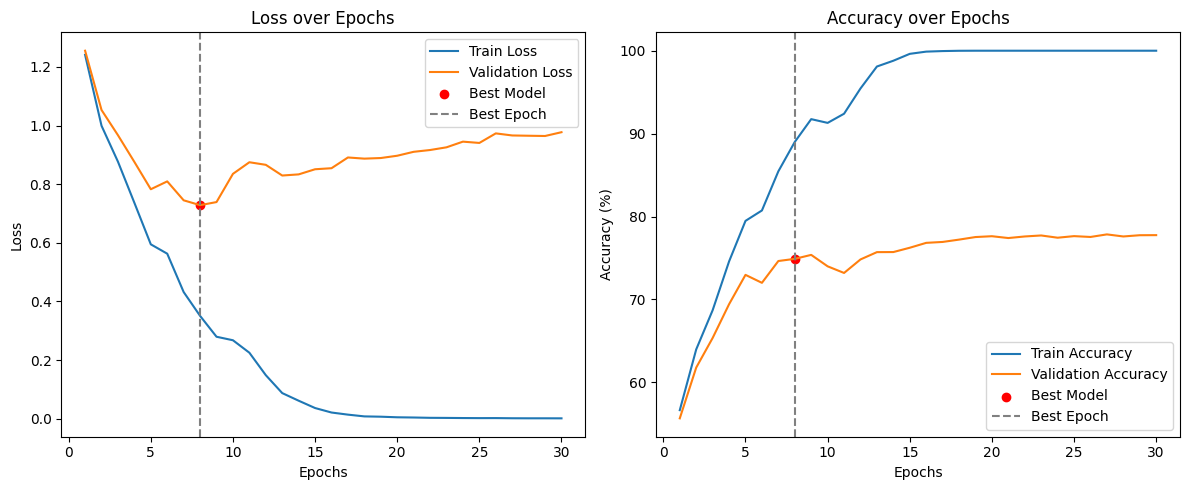

/tmp/ipykernel_23/3350674115.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))


Best model loaded from BMV2.pth.
Training completed. Best model saved at epoch 8.


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 190.38it/s]


Train Loss: 0.3508, Train Accuracy: 89.00%


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 187.30it/s]


Validation Loss: 0.7285, Validation Accuracy: 74.90%


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 190.91it/s]

Test Loss: 0.7426, Test Accuracy: 74.61%


In [33]:
# Initialize model, criterion, and optimizer
BMV2 = BaselineModel_v2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(BMV2.parameters(), lr=0.00125)

train_model(BMV2, train_loader, val_loader, test_loader, criterion, optimizer, device, "BMV2.pth", num_epochs=30)

## **As expected, by adding the normalization layer, the network's accuracy improved from 73.35% to 74.65%.**

# Dropout only

## Using only Dropout can still be an effective technique for regularizing your neural network to prevent overfitting. Dropout is a form of regularization that randomly sets a fraction of input units to zero during training, which helps the model generalize better by not relying too heavily on any particular set of neurons.

### Explanation:

- **Dropout in Convolutional Layers**: 
  - `Dropout2d` is used after the max pooling layer in the convolutional section to avoid overfitting.
- **Dropout in Fully Connected Layers**: 
  - `Dropout` is used after the activation functions in fully connected layers to prevent overfitting.

### Considerations When Using Only Dropout:

- **Regularization**: Dropout is primarily a regularization technique and helps in reducing overfitting by preventing co-adaptation of neurons.
- **Training Time**: Dropout can make the training process slightly slower since it effectively reduces the number of active neurons during training.
- **Test Time**: During evaluation, dropout is not applied, and the full network is used for prediction, providing more robust results.

### Then:

Using only Dropout can be an effective way to regularize your network and prevent overfitting, particularly if you don't use Batch Normalization. However, integrating both Batch Normalization and Dropout can sometimes yield better results by combining the benefits of both stabilization and regularization techniques. 

In [34]:
# Define the BaselineModel_v3
class BaselineModel_v3(nn.Module):
    def __init__(self):
        super(BaselineModel_v3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=320, kernel_size=3)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(6 * 6 * 320, 160)
        self.dropout1 = nn.Dropout(p=0.7)
        self.fc2 = nn.Linear(160, 80)
        self.dropout2 = nn.Dropout(p=0.7)
        self.fc3 = nn.Linear(80, 10)  # 10 classes for CIFAR-10    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        x = x.view(-1, 6 * 6 * 320)  # Flatten the tensor
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 195.88it/s]


Epoch [1/30] - Train Loss: 1.7386, Train Acc: 29.67% - Val Loss: 1.7426, Val Acc: 29.27%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 198.29it/s]


Epoch [2/30] - Train Loss: 1.7034, Train Acc: 37.64% - Val Loss: 1.7107, Val Acc: 37.66%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 194.58it/s]


Epoch [3/30] - Train Loss: 1.2983, Train Acc: 51.63% - Val Loss: 1.3153, Val Acc: 51.45%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 197.34it/s]


Epoch [4/30] - Train Loss: 1.1192, Train Acc: 60.19% - Val Loss: 1.1428, Val Acc: 59.58%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 193.64it/s]


Epoch [5/30] - Train Loss: 0.9459, Train Acc: 67.63% - Val Loss: 0.9874, Val Acc: 65.83%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 196.85it/s]


Epoch [6/30] - Train Loss: 0.8710, Train Acc: 69.63% - Val Loss: 0.9302, Val Acc: 67.78%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 193.04it/s]


Epoch [7/30] - Train Loss: 0.7469, Train Acc: 74.24% - Val Loss: 0.8363, Val Acc: 71.07%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 198.92it/s]


Epoch [8/30] - Train Loss: 0.6970, Train Acc: 75.96% - Val Loss: 0.8050, Val Acc: 72.56%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 192.94it/s]


Epoch [9/30] - Train Loss: 0.6338, Train Acc: 79.10% - Val Loss: 0.7653, Val Acc: 74.44%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 196.70it/s]


Epoch [10/30] - Train Loss: 0.5920, Train Acc: 80.03% - Val Loss: 0.7631, Val Acc: 74.23%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 194.79it/s]


Epoch [11/30] - Train Loss: 0.4950, Train Acc: 83.19% - Val Loss: 0.7120, Val Acc: 76.17%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 198.88it/s]


Epoch [12/30] - Train Loss: 0.4911, Train Acc: 83.71% - Val Loss: 0.7250, Val Acc: 76.10%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 195.19it/s]


Epoch [13/30] - Train Loss: 0.4048, Train Acc: 86.23% - Val Loss: 0.6774, Val Acc: 77.95%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 197.07it/s]


Epoch [14/30] - Train Loss: 0.3525, Train Acc: 88.18% - Val Loss: 0.6685, Val Acc: 78.39%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 196.91it/s]


Epoch [15/30] - Train Loss: 0.3198, Train Acc: 89.19% - Val Loss: 0.6684, Val Acc: 78.56%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 199.96it/s]


Epoch [16/30] - Train Loss: 0.3387, Train Acc: 88.51% - Val Loss: 0.7290, Val Acc: 76.88%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 196.63it/s]


Epoch [17/30] - Train Loss: 0.2759, Train Acc: 90.97% - Val Loss: 0.6869, Val Acc: 78.46%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 199.53it/s]


Epoch [18/30] - Train Loss: 0.2880, Train Acc: 90.30% - Val Loss: 0.7193, Val Acc: 77.88%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 195.94it/s]


Epoch [19/30] - Train Loss: 0.2129, Train Acc: 93.27% - Val Loss: 0.6928, Val Acc: 79.18%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 196.21it/s]


Epoch [20/30] - Train Loss: 0.2205, Train Acc: 93.12% - Val Loss: 0.7038, Val Acc: 79.53%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 191.73it/s]


Epoch [21/30] - Train Loss: 0.1725, Train Acc: 94.40% - Val Loss: 0.7017, Val Acc: 80.00%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 191.37it/s]


Epoch [22/30] - Train Loss: 0.1690, Train Acc: 94.76% - Val Loss: 0.7214, Val Acc: 79.36%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 194.12it/s]


Epoch [23/30] - Train Loss: 0.1539, Train Acc: 95.31% - Val Loss: 0.7223, Val Acc: 80.34%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 191.01it/s]


Epoch [24/30] - Train Loss: 0.1739, Train Acc: 93.95% - Val Loss: 0.8116, Val Acc: 78.47%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 198.26it/s]


Epoch [25/30] - Train Loss: 0.1296, Train Acc: 95.98% - Val Loss: 0.7566, Val Acc: 79.76%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 195.81it/s]


Epoch [26/30] - Train Loss: 0.1143, Train Acc: 96.39% - Val Loss: 0.7512, Val Acc: 80.07%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 196.97it/s]


Epoch [27/30] - Train Loss: 0.1133, Train Acc: 96.75% - Val Loss: 0.7437, Val Acc: 80.29%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 195.51it/s]


Epoch [28/30] - Train Loss: 0.1193, Train Acc: 96.36% - Val Loss: 0.7678, Val Acc: 79.98%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 197.27it/s]


Epoch [29/30] - Train Loss: 0.1168, Train Acc: 96.27% - Val Loss: 0.8645, Val Acc: 79.96%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 196.08it/s]


Epoch [30/30] - Train Loss: 0.0907, Train Acc: 97.29% - Val Loss: 0.8384, Val Acc: 79.72%


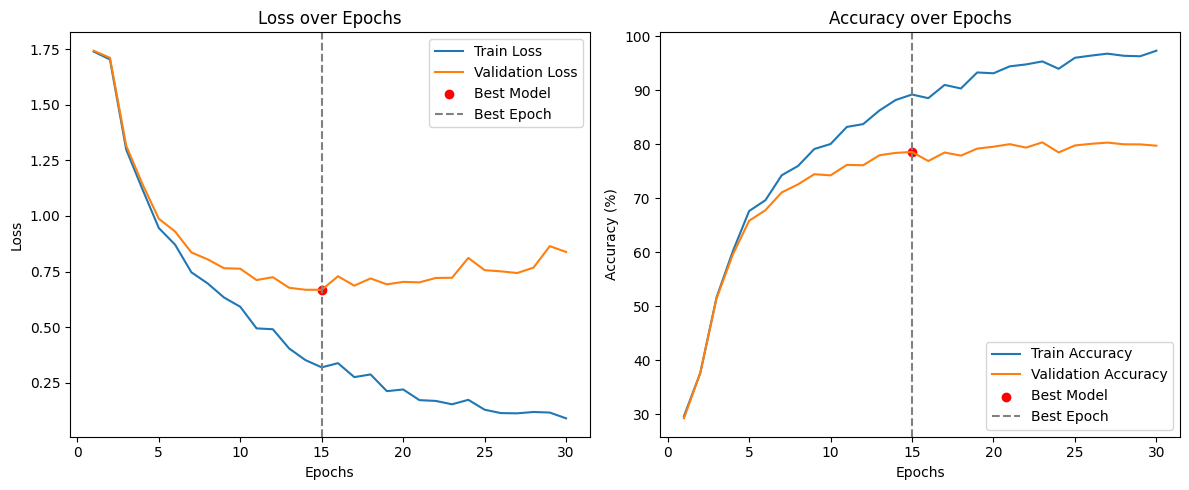

/tmp/ipykernel_23/3350674115.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))


Best model loaded from BMV3.pth.
Training completed. Best model saved at epoch 15.


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 196.38it/s]


Train Loss: 0.3198, Train Accuracy: 89.19%


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 195.66it/s]


Validation Loss: 0.6684, Validation Accuracy: 78.56%


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 196.14it/s]

Test Loss: 0.7068, Test Accuracy: 78.53%


In [35]:
# Initialize model, criterion, and optimizer
BMV3 = BaselineModel_v3()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(BMV3.parameters(), lr=0.02)

train_model(BMV3, train_loader, val_loader, test_loader, criterion, optimizer, device, "BMV3.pth", num_epochs=30)

## **As expected, the use of dropout layers as a regularization technique also performed well, increasing the model's accuracy to 78%.**

# Using Dropout and Batch Normalization together
- **Batch Normalization**: Used after convolutional and fully connected layers to normalize activations.
- **Dropout**: Applied after activation functions in fully connected layers to prevent overfitting.

This setup combines the benefits of both techniques to enhance the training process and improve model performance. If you have any more questions or need further clarification, feel free to ask!

In [36]:
class BaselineModel_v4(nn.Module):
    def __init__(self):
        super(BaselineModel_v4, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=320, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(320)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(6 * 6 * 320, 160)
        self.dropout1 = nn.Dropout(p=0.5)  # Dropout with 50% probability
        self.fc2 = nn.Linear(160, 80)
        self.dropout2 = nn.Dropout(p=0.5)  # Dropout with 50% probability
        self.fc3 = nn.Linear(80, 10)  # 10 classes for CIFAR-10

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        x = x.view(-1, 6 * 6 * 320)  # Flatten the tensor
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 191.91it/s]


Epoch [1/30] - Train Loss: 1.5112, Train Acc: 47.57% - Val Loss: 1.5182, Val Acc: 47.30%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 194.00it/s]


Epoch [2/30] - Train Loss: 1.2871, Train Acc: 55.35% - Val Loss: 1.3033, Val Acc: 54.82%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 194.83it/s]


Epoch [3/30] - Train Loss: 1.1064, Train Acc: 60.31% - Val Loss: 1.1323, Val Acc: 59.28%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 188.65it/s]


Epoch [4/30] - Train Loss: 1.0070, Train Acc: 64.61% - Val Loss: 1.0502, Val Acc: 63.04%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 194.66it/s]


Epoch [5/30] - Train Loss: 0.9069, Train Acc: 68.10% - Val Loss: 0.9660, Val Acc: 65.61%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 194.39it/s]


Epoch [6/30] - Train Loss: 0.8247, Train Acc: 71.01% - Val Loss: 0.8983, Val Acc: 68.70%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 191.76it/s]


Epoch [7/30] - Train Loss: 0.7933, Train Acc: 72.44% - Val Loss: 0.8785, Val Acc: 69.39%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 194.47it/s]


Epoch [8/30] - Train Loss: 0.7170, Train Acc: 75.35% - Val Loss: 0.8190, Val Acc: 71.44%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 190.95it/s]


Epoch [9/30] - Train Loss: 0.6888, Train Acc: 77.12% - Val Loss: 0.8123, Val Acc: 71.81%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 191.16it/s]


Epoch [10/30] - Train Loss: 0.6389, Train Acc: 77.65% - Val Loss: 0.7844, Val Acc: 72.61%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 193.72it/s]


Epoch [11/30] - Train Loss: 0.5883, Train Acc: 80.06% - Val Loss: 0.7570, Val Acc: 74.47%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 192.33it/s]


Epoch [12/30] - Train Loss: 0.5324, Train Acc: 81.60% - Val Loss: 0.7100, Val Acc: 75.21%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 189.73it/s]


Epoch [13/30] - Train Loss: 0.5004, Train Acc: 82.78% - Val Loss: 0.6987, Val Acc: 75.80%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 195.51it/s]


Epoch [14/30] - Train Loss: 0.4678, Train Acc: 83.94% - Val Loss: 0.6962, Val Acc: 75.99%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 196.49it/s]


Epoch [15/30] - Train Loss: 0.4390, Train Acc: 84.67% - Val Loss: 0.6880, Val Acc: 76.37%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 193.74it/s]


Epoch [16/30] - Train Loss: 0.4134, Train Acc: 86.51% - Val Loss: 0.6803, Val Acc: 77.09%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 193.01it/s]


Epoch [17/30] - Train Loss: 0.3705, Train Acc: 87.79% - Val Loss: 0.6757, Val Acc: 77.14%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 192.45it/s]


Epoch [18/30] - Train Loss: 0.3471, Train Acc: 88.52% - Val Loss: 0.6856, Val Acc: 77.14%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 191.69it/s]


Epoch [19/30] - Train Loss: 0.2924, Train Acc: 90.36% - Val Loss: 0.6472, Val Acc: 78.17%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 192.35it/s]


Epoch [20/30] - Train Loss: 0.3003, Train Acc: 91.17% - Val Loss: 0.6611, Val Acc: 77.99%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 192.13it/s]


Epoch [21/30] - Train Loss: 0.2583, Train Acc: 91.32% - Val Loss: 0.6848, Val Acc: 77.67%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 189.38it/s]


Epoch [22/30] - Train Loss: 0.2469, Train Acc: 92.05% - Val Loss: 0.6838, Val Acc: 78.26%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 193.87it/s]


Epoch [23/30] - Train Loss: 0.2299, Train Acc: 92.34% - Val Loss: 0.7131, Val Acc: 77.86%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 190.38it/s]


Epoch [24/30] - Train Loss: 0.1961, Train Acc: 93.72% - Val Loss: 0.6976, Val Acc: 78.43%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 189.70it/s]


Epoch [25/30] - Train Loss: 0.1691, Train Acc: 94.78% - Val Loss: 0.6826, Val Acc: 78.40%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 195.59it/s]


Epoch [26/30] - Train Loss: 0.1406, Train Acc: 95.72% - Val Loss: 0.6736, Val Acc: 79.05%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 188.54it/s]


Epoch [27/30] - Train Loss: 0.1505, Train Acc: 95.13% - Val Loss: 0.7129, Val Acc: 78.29%


Evaluating: 100%|██████████| 2500/2500 [00:13<00:00, 191.24it/s]


Epoch [28/30] - Train Loss: 0.1154, Train Acc: 96.25% - Val Loss: 0.7256, Val Acc: 78.88%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 195.05it/s]


Epoch [29/30] - Train Loss: 0.1142, Train Acc: 96.58% - Val Loss: 0.7143, Val Acc: 79.19%


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 192.36it/s]


Epoch [30/30] - Train Loss: 0.1244, Train Acc: 96.07% - Val Loss: 0.7913, Val Acc: 77.46%


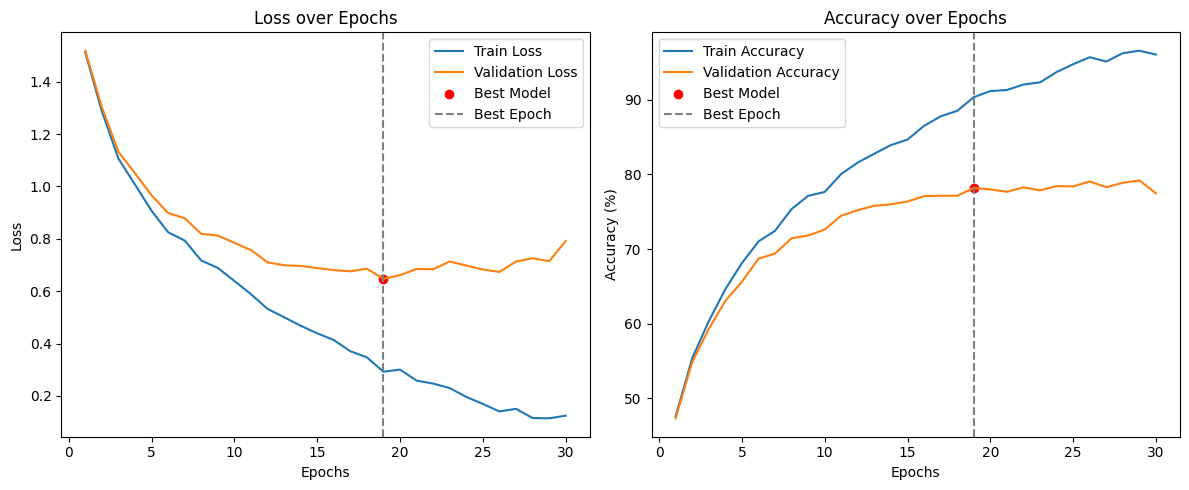

/tmp/ipykernel_23/3350674115.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))


Best model loaded from BMV4.pth.
Training completed. Best model saved at epoch 19.


Evaluating: 100%|██████████| 2500/2500 [00:12<00:00, 193.76it/s]


Train Loss: 0.2924, Train Accuracy: 90.36%


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 193.56it/s]


Validation Loss: 0.6472, Validation Accuracy: 78.17%


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 191.50it/s]

Test Loss: 0.6590, Test Accuracy: 77.90%


In [37]:
# Initialize model, criterion, and optimizer
BMV4 = BaselineModel_v4()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(BMV4.parameters(), lr=0.00125)

train_model(BMV4, train_loader, val_loader, test_loader, criterion, optimizer, device, "BMV4.pth", num_epochs=30)

## **Ultimately, the simultaneous use of both dropout and normalization layers increases the model's accuracy to 78%. It's worth noting that in the network where only dropout was used as a regularization technique, the learning rate was quite high, which is why the accuracy was slightly better than in the case where both normalization and dropout were applied.**

/tmp/ipykernel_23/3061913759.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))
Evaluating: 100%|██████████| 625/625 [00:02<00:00, 

Model: baseline model
Test Loss: 1.0667, Test Accuracy: 64.2100


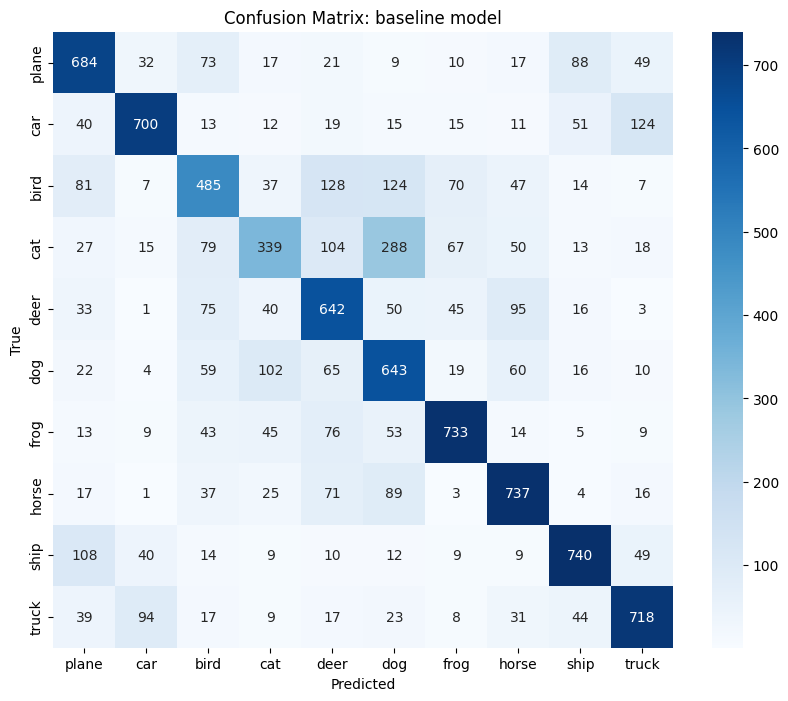

/tmp/ipykernel_23/3061913759.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 198.73it/s]


Model: model with no Regularization
Test Loss: 0.7988, Test Accuracy: 73.3500


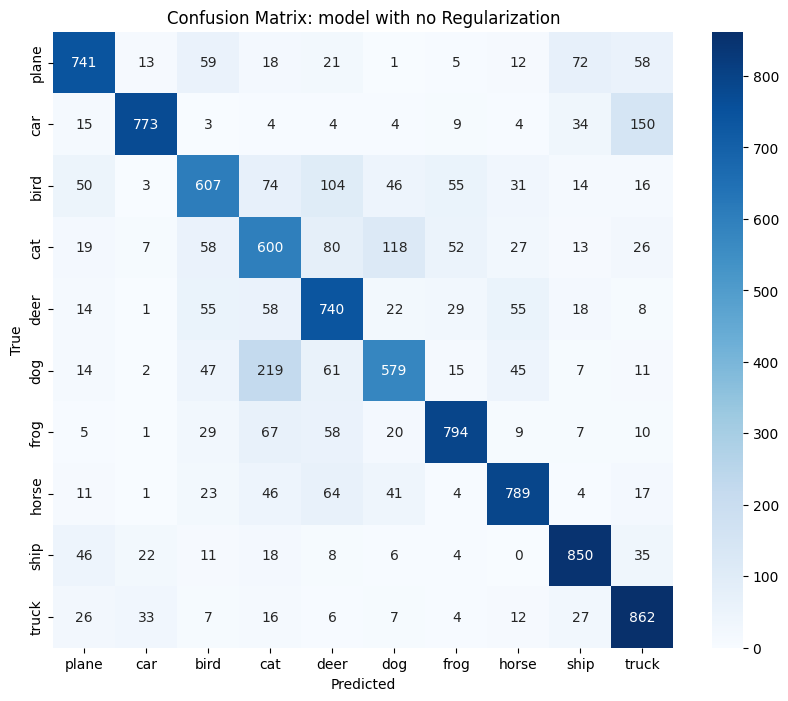

/tmp/ipykernel_23/3061913759.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 192.22it/s]


Model: model with Batch Normalization
Test Loss: 0.7426, Test Accuracy: 74.6100


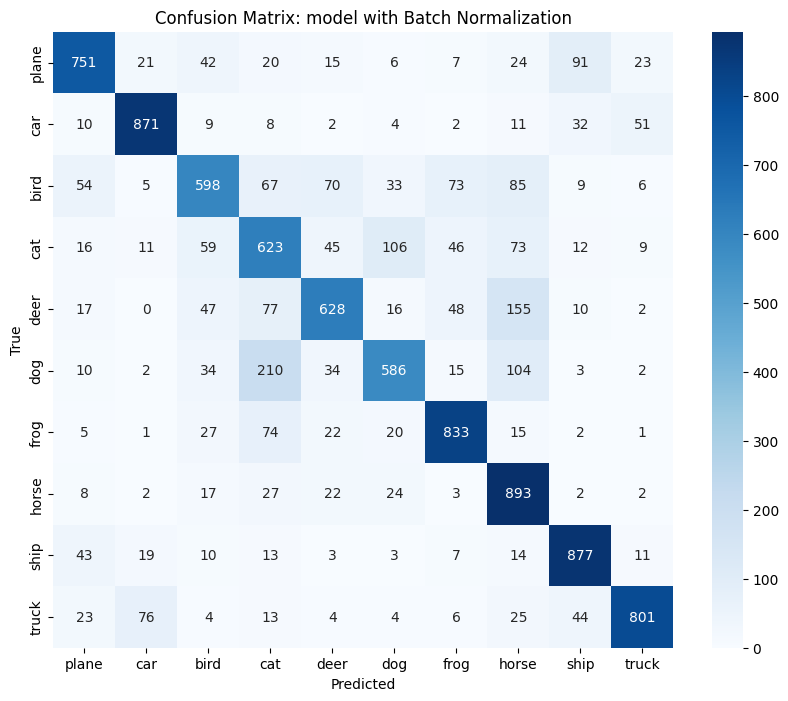

/tmp/ipykernel_23/3061913759.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 197.11it/s]


Model: model with only Dropout
Test Loss: 0.7068, Test Accuracy: 78.5300


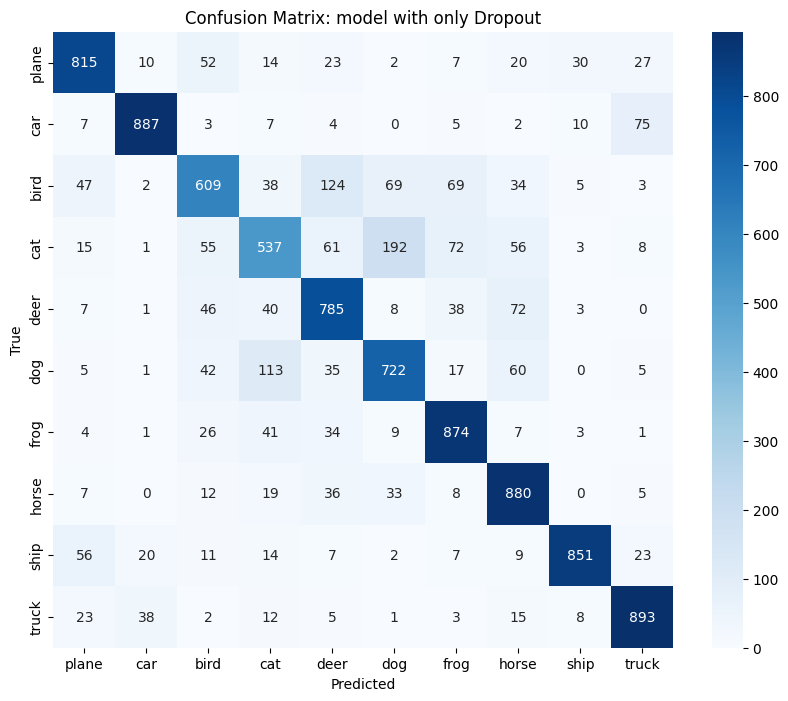

/tmp/ipykernel_23/3061913759.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 192.61it/s]


Model: model with Batch Normalization and Dropout
Test Loss: 0.6590, Test Accuracy: 77.9000


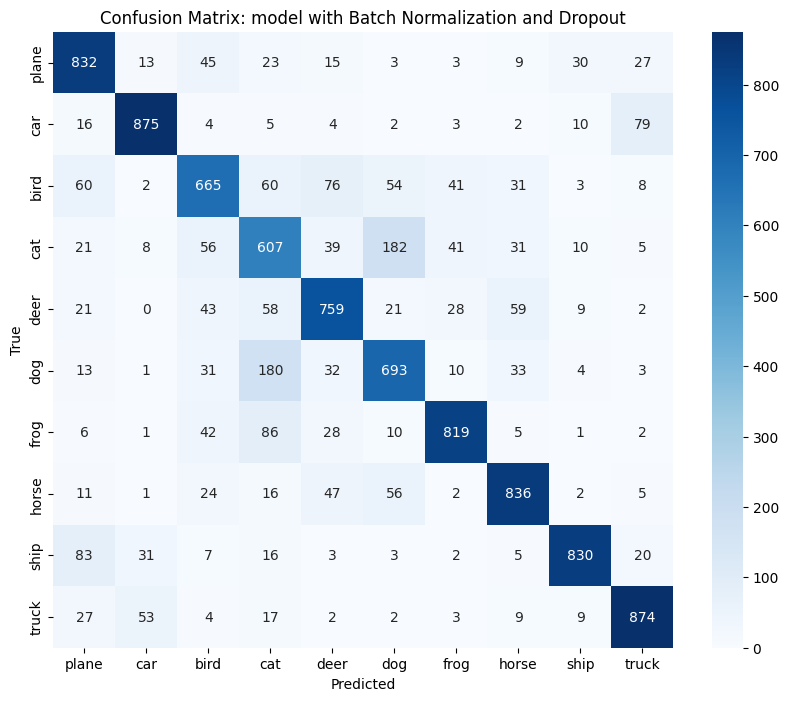

In [38]:
# CIFAR-10 class names
class_names = [
    "plane", "car", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Assuming model_list, test_loader, and other necessary variables are defined elsewhere
model_list = [BMV0, BMV1, BMV2, BMV3, BMV4]
path_list = ["BMV0.pth", "BMV1.pth", "BMV2.pth", "BMV3.pth", "BMV4.pth"]
model_detail = [
    "baseline model", 
    "model with no Regularization", 
    "model with Batch Normalization", 
    "model with only Dropout", 
    "model with Batch Normalization and Dropout"
]

criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for model, path, detail in zip(model_list, path_list, model_detail):
    # Load the model weights
    model.load_state_dict(torch.load(path))
    model.to(device)  # Move model to device
    model.eval()  # Set model to evaluation mode

    running_loss, correct, total = 0.0, 0, 0
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating", leave=True):
            images, labels = images.to(device), labels.to(device)  # Move data to device
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            y_true.extend(labels.cpu().numpy())  # Flatten and append to y_true
            y_pred.extend(predicted.cpu().numpy())  # Flatten and append to y_pred

    test_loss = running_loss / len(test_loader)
    test_acc = 100 * correct / total
    
    # Print model details
    print(f"Model: {detail}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title(f'Confusion Matrix: {detail}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    print(50 * "=")